# add_trades_parallel


This sample creates a strategy comprising JSON trade records<br>
and verifies the strategy.<br>


## Imports

In [1]:
from datetime import datetime
import json
import os
import pprint
import random
import subprocess
import sys
import time
from concurrent.futures import ThreadPoolExecutor
from dotenv import load_dotenv
import matplotlib.pyplot as plt

In [2]:
from vbase import (
    VBaseClient,
    ForwarderCommitmentService,
    VBaseDataset,
    VBaseJsonObject,
)

In [3]:
from aws_utils import (
    create_s3_client_from_env,
    create_s3_objects_from_dataset,
    init_vbase_dataset_from_s3_objects,
)

## Configuration

The sample uses 5 users with strategies and 10 trades per strategy.

In [4]:
N_USERS = 5
N_TRADES = 10

Use hardcoded test accounts for the example.<br>
Each account is defined by the private key that gives owners control of their data.

In [5]:
l_accounts = [
    {
        "pk": "0xabfc6c981e4e9f1f26175bc40aef73248d467617309c5e04e83da34171999076",
        "address": "0xA401F59d7190E4448Eb60691E3bc78f1Ef03e88C",
    },
    {
        "pk": "0x422043f88fbd2f605f0237512e090032ad90c0a5583df4a189f446ab7abf779a",
        "address": "0xEe8633d1fC69d045442Da84f08DF49C48826b163",
    },
    {
        "pk": "0x321c704b7edbeec46a1200f6862548604ba255e2c1f7dd08e9c1d18fcfc0cfb9",
        "address": "0x7e3CB5Bc50E1864b3Dc863299b4A4269D12928f1",
    },
    {
        "pk": "0x7d0776af9f1eac044e9d390a84a9a3608350ebce036bc0215e6b19c77d51f700",
        "address": "0xcd9b43102E26d3191a7a76eA98dF858daa1e34Ae",
    },
    {
        "pk": "0x63716eb43c9a84224715bcf5dd901e9dd3100791526dc65993898c0a676ffa68",
        "address": "0xd991dc481319fb3C93fe01d124a4ae0b197FcB8B",
    },
]

S3 bucket for the test data.

In [6]:
BUCKET_NAME = "vbase-test"

Name of the source S3 folder for the dataset records.

In [7]:
FOLDER_NAME = f"add_trades_parallel/{datetime.now().strftime('%Y%m%d%H%M%S')}/"

Check if the script is running in an interactive mode or a Jupyter notebook.

In [8]:
if "ipykernel" not in sys.modules and "IPython" in sys.modules:
    # Load support for HTML display, if necessary.
    from IPython.display import display, HTML

    # The following line creates overactive warning.
    # We want the import within the clause.
    # pylint: disable=ungrouped-imports
    import matplotlib

    # Set plot backend to WebAgg.
    # This backend provides interactive web charts.
    matplotlib.use("WebAgg")

## Setup

Load the information necessary to call vBase APIs.

In [9]:
load_dotenv(verbose=True, override=True)
forwarder_url = os.environ.get("VBASE_FORWARDER_URL")
api_key = os.environ.get("VBASE_API_KEY")

Create an AWS client using environment variables.

In [10]:
boto_client = create_s3_client_from_env()

Create strategy data.<br>
This is the data users will be using to post trades.<br>
We will simulate multiple users and strategies using multiple threads,<br>
with each thread using a given strategy dataset.

In [11]:
l_starts = []
for i_user in range(N_USERS):
    vbc = VBaseClient(
        ForwarderCommitmentService(
            forwarder_url,
            api_key,
            l_accounts[i_user]["pk"],
        )
    )
    strategy_data = {
        "name": (f"user{i_user}_strategy" + datetime.now().strftime("%Y%m%d%H%M%S")),
        "address": l_accounts[i_user]["address"],
        "vbc": vbc,
    }
    l_starts.append(strategy_data)

In [12]:
print(f"Created users and strategies:\n{pprint.pformat(l_starts)}")

Created users and strategies:
[{'address': '0xA401F59d7190E4448Eb60691E3bc78f1Ef03e88C',
  'name': 'user0_strategy20240513131645',
  'vbc': <vbase.core.vbase_client.VBaseClient object at 0x7f37cf7074f0>},
 {'address': '0xEe8633d1fC69d045442Da84f08DF49C48826b163',
  'name': 'user1_strategy20240513131645',
  'vbc': <vbase.core.vbase_client.VBaseClient object at 0x7f37c6362f40>},
 {'address': '0x7e3CB5Bc50E1864b3Dc863299b4A4269D12928f1',
  'name': 'user2_strategy20240513131645',
  'vbc': <vbase.core.vbase_client.VBaseClient object at 0x7f37c633be80>},
 {'address': '0xcd9b43102E26d3191a7a76eA98dF858daa1e34Ae',
  'name': 'user3_strategy20240513131645',
  'vbc': <vbase.core.vbase_client.VBaseClient object at 0x7f37c63a5fa0>},
 {'address': '0xd991dc481319fb3C93fe01d124a4ae0b197FcB8B',
  'name': 'user4_strategy20240513131645',
  'vbc': <vbase.core.vbase_client.VBaseClient object at 0x7f37c6277610>}]


## Create Strategy Datasets

In [13]:
def create_strategy_dataset(i_strat):
    """
    Create the strategy dataset
    :param i_strat: Strategy index
    """
    # Create the vBase dataset object.
    ds_strat = VBaseDataset(
        l_starts[i_strat]["vbc"], l_starts[i_strat]["name"], VBaseJsonObject
    )
    print(f"Created dataset: {pprint.pformat(ds_strat.to_dict())}")
    return ds_strat

In [14]:
with ThreadPoolExecutor(max_workers=len(l_starts)) as executor:
    results = executor.map(create_strategy_dataset, range(len(l_starts)))
l_datasets = list(results)

Created dataset: {'cid': '0xabb0cc340e695365d7592425fb3f24acbd2c07095aaa3ccc0139cc530d235ee3',
 'name': 'user4_strategy20240513131645',
 'owner': '0xd991dc481319fb3C93fe01d124a4ae0b197FcB8B',
 'record_type_name': 'VBaseJsonObject',
 'records': [],
 'timestamps': []}
Created dataset: {'cid': '0x6e163811c51c460902605369fbf76d5f710621d9be3631b6b94c432e0a0933de',
 'name': 'user0_strategy20240513131645',
 'owner': '0xA401F59d7190E4448Eb60691E3bc78f1Ef03e88C',
 'record_type_name': 'VBaseJsonObject',
 'records': [],
 'timestamps': []}
Created dataset: {'cid': '0x9e96fd86bee08ee320f735431ef296cdc12dfbf937f1c1a61416248105a38b06',
 'name': 'user3_strategy20240513131645',
 'owner': '0xcd9b43102E26d3191a7a76eA98dF858daa1e34Ae',
 'record_type_name': 'VBaseJsonObject',
 'records': [],
 'timestamps': []}
Created dataset: {'cid': '0xec63b24284f3110cba8e31911debb9e2159d1cae98ecd22dac0f80f2d1f15f45',
 'name': 'user2_strategy20240513131645',
 'owner': '0x7e3CB5Bc50E1864b3Dc863299b4A4269D12928f1',
 'recor

## Post Trades

In [21]:
def post_strategy_trades(i_strat):
    """
    Post trades for a strategy
    :param i_strat: Strategy index
    """
    trades = []
    receipts = []
    # Create a set of pseudorandom trades with a reproducible seed.
    random.seed(i_strat)
    for i_trade in range(N_TRADES):
        trade = json.dumps(
            {
                "trade_id": i_trade,
                "symbol": "ETHUSD",
                # Create a random trade in [-1, 1].
                "size": round(random.random() * 2 - 1, 2),
            }
        )
        trades.append(trade)
        # Add trade to the vBase dataset object.
        receipt = l_datasets[i_strat].add_record(trade)
        print(f"Posted trade: {pprint.pformat(receipt)}")
        receipts.append(receipt)
    return trades, receipts

In [16]:
start_time = time.time()
with ThreadPoolExecutor(max_workers=len(l_starts)) as executor:
    results = executor.map(post_strategy_trades, range(len(l_starts)))
elapsed_time = time.time() - start_time
l_trades, l_receipts = zip(*results)

Posted trade: {'objectCid': '0xf4adc1279ad6b7d025ce06de4a7ab4d699f3a71f43bcc3ce3d0127c2fd3828fa',
 'timestamp': '2024-05-13 20:22:38+00:00',
 'user': '0xA401F59d7190E4448Eb60691E3bc78f1Ef03e88C'}
Posted trade: {'objectCid': '0xeb331fdf4d48cb5edc85424baf685d9f1c544b702f9ae135396b4bd7be8da74f',
 'timestamp': '2024-05-13 20:22:39+00:00',
 'user': '0xcd9b43102E26d3191a7a76eA98dF858daa1e34Ae'}
Posted trade: {'objectCid': '0xae4a66383ad8cb6179cac97fc9bb5eec634ed43da28673662cf96cba4478d27f',
 'timestamp': '2024-05-13 20:22:39+00:00',
 'user': '0x7e3CB5Bc50E1864b3Dc863299b4A4269D12928f1'}
Posted trade: {'objectCid': '0xd7511b10f36e0b5ea59e7fdfc9f629ffe4d2be845ae9d5e489e2b5b893acd032',
 'timestamp': '2024-05-13 20:22:39+00:00',
 'user': '0xEe8633d1fC69d045442Da84f08DF49C48826b163'}
Posted trade: {'objectCid': '0x8b1e72c5faaaf7790d6332bbef75d7d6807346d0270eae1ec6a5cc32fb218287',
 'timestamp': '2024-05-13 20:22:39+00:00',
 'user': '0xd991dc481319fb3C93fe01d124a4ae0b197FcB8B'}
Posted trade: {'obje

In [18]:
print(f"Trades: {N_USERS * N_TRADES}")
print(f"Time elapsed (sec.): {elapsed_time}")
print(f"Throughput (trades/min.): {N_USERS * N_TRADES / elapsed_time * 60}")

Trades: 50
Time elapsed (sec.): 32.781461238861084
Throughput (trades/min.): 91.51513955221809


Save all the posted trades.

In [19]:
for ds in l_datasets:
    print(f"Saving dataset: {ds.name}")
    create_s3_objects_from_dataset(ds, boto_client, BUCKET_NAME, FOLDER_NAME)

Saving dataset: user0_strategy20240513131645
Created S3 object: add_trades_parallel/20240513131631/user0_strategy20240513131645/obj_0.json
Created S3 object: add_trades_parallel/20240513131631/user0_strategy20240513131645/obj_1.json
Created S3 object: add_trades_parallel/20240513131631/user0_strategy20240513131645/obj_2.json
Created S3 object: add_trades_parallel/20240513131631/user0_strategy20240513131645/obj_3.json
Created S3 object: add_trades_parallel/20240513131631/user0_strategy20240513131645/obj_4.json
Created S3 object: add_trades_parallel/20240513131631/user0_strategy20240513131645/obj_5.json
Created S3 object: add_trades_parallel/20240513131631/user0_strategy20240513131645/obj_6.json
Created S3 object: add_trades_parallel/20240513131631/user0_strategy20240513131645/obj_7.json
Created S3 object: add_trades_parallel/20240513131631/user0_strategy20240513131645/obj_8.json
Created S3 object: add_trades_parallel/20240513131631/user0_strategy20240513131645/obj_9.json
Saving dataset:

Display saved data using the shell.

In [20]:
for ds in l_datasets:
    print(f"Displaying S3 objects for dataset: {ds.name}")
    for i in range(len(ds.records)):
        command = f"curl https://vbase-test.s3.amazonaws.com/{FOLDER_NAME}{ds.name}/obj_{i}.json"
        print(command)
        process = subprocess.run(
            command, shell=True, text=True, capture_output=True, check=True
        )
        print(process.stdout)

Displaying S3 objects for dataset: user0_strategy20240513131645
curl https://vbase-test.s3.amazonaws.com/add_trades_parallel/20240513131631/user0_strategy20240513131645/obj_0.json
{"trade_id": 0, "symbol": "ETHUSD", "size": 0.6888437030500962}
curl https://vbase-test.s3.amazonaws.com/add_trades_parallel/20240513131631/user0_strategy20240513131645/obj_1.json
{"trade_id": 1, "symbol": "ETHUSD", "size": -0.7936679315385684}
curl https://vbase-test.s3.amazonaws.com/add_trades_parallel/20240513131631/user0_strategy20240513131645/obj_2.json
{"trade_id": 2, "symbol": "ETHUSD", "size": 0.8359100861754378}
curl https://vbase-test.s3.amazonaws.com/add_trades_parallel/20240513131631/user0_strategy20240513131645/obj_3.json
{"trade_id": 3, "symbol": "ETHUSD", "size": -0.44663471311709957}
curl https://vbase-test.s3.amazonaws.com/add_trades_parallel/20240513131631/user0_strategy20240513131645/obj_4.json
{"trade_id": 4, "symbol": "ETHUSD", "size": 0.6578400975568388}
curl https://vbase-test.s3.amazon

## Validate Trades

Create a strategy dataset to validate.<br>
This is done on the consumer/validator machine<br>
using data specified by the producer/prover.

In [26]:
ds_consumer = VBaseDataset(
    vbc=VBaseClient(ForwarderCommitmentService(forwarder_url, api_key)),
    init_dict={
        "name": l_datasets[0].name,
        "owner": l_datasets[0].owner,
        "record_type_name": "VBaseJsonObject",
        "records": [],
    },
)

Load dataset records from the bucket.

In [27]:
init_vbase_dataset_from_s3_objects(
    ds_consumer, boto_client, BUCKET_NAME, FOLDER_NAME + ds_consumer.name
)
print(
    f"Consumer dataset before timestamp validation:\n{pprint.pformat(ds_consumer.to_dict())}"
)

Consumer dataset before timestamp validation:
{'cid': '0x6e163811c51c460902605369fbf76d5f710621d9be3631b6b94c432e0a0933de',
 'name': 'user0_strategy20240513131645',
 'owner': '0xA401F59d7190E4448Eb60691E3bc78f1Ef03e88C',
 'record_type_name': 'VBaseJsonObject',
 'records': [{'cid': None,
              'data': '{"trade_id": 0, "symbol": "ETHUSD", "size": '
                      '0.6888437030500962}'},
             {'cid': None,
              'data': '{"trade_id": 1, "symbol": "ETHUSD", "size": '
                      '-0.7936679315385684}'},
             {'cid': None,
              'data': '{"trade_id": 2, "symbol": "ETHUSD", "size": '
                      '0.8359100861754378}'},
             {'cid': None,
              'data': '{"trade_id": 3, "symbol": "ETHUSD", "size": '
                      '-0.44663471311709957}'},
             {'cid': None,
              'data': '{"trade_id": 4, "symbol": "ETHUSD", "size": '
                      '0.6578400975568388}'},
             {'cid': None,

Restore timestamps using commitments and display the validated dataset.

In [28]:
ds_consumer.try_restore_timestamps_from_index()
print(
    f"Copy dataset after timestamp validation:\n{pprint.pformat(ds_consumer.to_dict())}"
)

Copy dataset after timestamp validation:
{'cid': '0x6e163811c51c460902605369fbf76d5f710621d9be3631b6b94c432e0a0933de',
 'name': 'user0_strategy20240513131645',
 'owner': '0xA401F59d7190E4448Eb60691E3bc78f1Ef03e88C',
 'record_type_name': 'VBaseJsonObject',
 'records': [{'cid': '0xf4adc1279ad6b7d025ce06de4a7ab4d699f3a71f43bcc3ce3d0127c2fd3828fa',
              'data': '{"trade_id": 0, "symbol": "ETHUSD", "size": '
                      '0.6888437030500962}'},
             {'cid': '0xcf0929e381a99c48c9bf188fa31d4a8491882d43de108cef9813e637e98eda86',
              'data': '{"trade_id": 1, "symbol": "ETHUSD", "size": '
                      '-0.7936679315385684}'},
             {'cid': '0xd08ca3b4069fb4f3644acaf3010291a4ba8010b5e9ade3b1efa8da336830af81',
              'data': '{"trade_id": 2, "symbol": "ETHUSD", "size": '
                      '0.8359100861754378}'},
             {'cid': '0x6022709acff915c9638b3f05e4d015afd389142d409b666161d04075cc1210a3',
              'data': '{"trade_id"

Print a table of the trades and transaction hash links.

In [31]:
%%capture
l_receipts = ds_consumer.get_commitment_receipts()
print("num\ttrade\ttrade_hash\ttx")
for i, record in enumerate(ds_consumer.records):
    print(f"{i}\t{record.data}\t{record.cid}\t{l_receipts[i]['transactionHash']}")

Start building the HTML table.

In [47]:
html = "<table>"
html += "<tr><th>num</th><th>trade</th><th>trade_hash</th><th>blockchain_transaction_hash</th></tr>"
# Populate the table with data.
for i, record in enumerate(ds_consumer.records):
    tx_hash = l_receipts[i]['transactionHash']
    html += (f"<tr><td>{i}</td><td>{record.data}</td><td>{record.cid}</td>"
             f"<td><a href=\"https://sepolia.arbiscan.io/tx/{tx_hash}\">{tx_hash}</a></td></tr>")
html += "</table>"

Check if the script is running in an interactive mode or a Jupyter notebook.

In [48]:
if "ipykernel" not in sys.modules and "IPython" in sys.modules:
    pprint.pprint(html)
else:
    # Load support for HTML display, if necessary.
    from IPython.display import display, HTML
    # Display the HTML table in the Jupyter notebook.
    display(HTML(html))

num,trade,trade_hash,blockchain_transaction_hash
0,"{""trade_id"": 0, ""symbol"": ""ETHUSD"", ""size"": 0.6888437030500962}",0xf4adc1279ad6b7d025ce06de4a7ab4d699f3a71f43bcc3ce3d0127c2fd3828fa,0x832ff1d365b9bbec69284b80e7d53251f5fc85a0fa0e626e64236d293fe0bdfa
1,"{""trade_id"": 1, ""symbol"": ""ETHUSD"", ""size"": -0.7936679315385684}",0xcf0929e381a99c48c9bf188fa31d4a8491882d43de108cef9813e637e98eda86,0xa18f90595acc4b80e7edb35a04a0807018516d1402147f62c12fc82dbcec56a0
2,"{""trade_id"": 2, ""symbol"": ""ETHUSD"", ""size"": 0.8359100861754378}",0xd08ca3b4069fb4f3644acaf3010291a4ba8010b5e9ade3b1efa8da336830af81,0x8e61e04d5e99526148933b8017e5483a3d0f8d8c6fe4c0d2c4924234dfeec856
3,"{""trade_id"": 3, ""symbol"": ""ETHUSD"", ""size"": -0.44663471311709957}",0x6022709acff915c9638b3f05e4d015afd389142d409b666161d04075cc1210a3,0xa2cfb3b636489aa8080eb6e8cc8f60b3dc2ca8fdeadb596f153635646832dcab
4,"{""trade_id"": 4, ""symbol"": ""ETHUSD"", ""size"": 0.6578400975568388}",0x2cce254eebabd4a9f30b1985cd87c5c0efea1f435c6296b25380db52571ebb29,0xbe5e3f8e338ab48aade7d5df5107002cc86d9365d86da65026ad532b3bfa6f7c
5,"{""trade_id"": 5, ""symbol"": ""ETHUSD"", ""size"": -0.38030008540092886}",0xf22ef0b416a54702c68dc0d33d4c73561df6157ddcd5a6bf6e98202017f4ea2b,0xfeadcbb1ac0882138901cca63125e8713dcb54dbe302628c55fd81943df44853
6,"{""trade_id"": 6, ""symbol"": ""ETHUSD"", ""size"": 0.7092967159826944}",0xa2f41e02f18c698577b706799f174f48f0e933e92c207e365c704a4d60355d77,0x105385a033498aec652eb44ac9e5d863c7da28908395f025407f58fa70f754a0
7,"{""trade_id"": 7, ""symbol"": ""ETHUSD"", ""size"": -0.8213075854692193}",0x914abbda3866fa722cef24a402afb56bdd82418e3b187281d09b90b1b24b9bcd,0x7551481c0db137019c0306238f96ec2c749a1773e286a272a296826cdb8433a5
8,"{""trade_id"": 8, ""symbol"": ""ETHUSD"", ""size"": 0.7309683403701666}",0x12067d83820e898961db094ab2b6742c228c1c6e43427423328be8d1135c0d58,0x16c5082b1b1b18e6069a1cd739bbd45ed3781f2c0fd5d6acc9cea3ef3b4cb7c5
9,"{""trade_id"": 9, ""symbol"": ""ETHUSD"", ""size"": 0.016744750665503183}",0xf46fbf9eac92af347ba7ddf72dad6d0d7de5882c914089081704a45fc90dd02e,0xd9b35f7be057ccc9d0bc668458f8d949dfd5400952363b2a1394decf592608ce


Plot the cumulative strategy return<br>
using a fictional return series.

Strategy trades DataFrame:
                            trade_id  symbol      size
2024-05-13 20:22:38+00:00         0  ETHUSD  0.688844
2024-05-13 20:22:41+00:00         1  ETHUSD -0.793668
2024-05-13 20:22:43+00:00         2  ETHUSD  0.835910
2024-05-13 20:22:46+00:00         3  ETHUSD -0.446635
2024-05-13 20:22:49+00:00         4  ETHUSD  0.657840
2024-05-13 20:22:52+00:00         5  ETHUSD -0.380300
2024-05-13 20:22:55+00:00         6  ETHUSD  0.709297
2024-05-13 20:22:58+00:00         7  ETHUSD -0.821308
2024-05-13 20:23:01+00:00         8  ETHUSD  0.730968
2024-05-13 20:23:05+00:00         9  ETHUSD  0.016745

Strategy cumulative return:


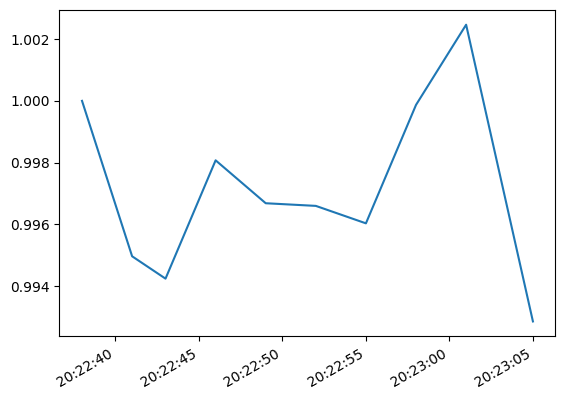

In [49]:
random.seed(1)
returns = [(random.random() * 2 - 1) / 100 for i in range(df.shape[0])]
df = ds_consumer.get_pd_data_frame()
print("Strategy trades DataFrame:\n", df)
df["wt"] = df["size"].cumsum()
(1 + df["wt"] * returns).cumprod().shift(1).fillna(1).plot()
print("\nStrategy cumulative return:")
plt.show()